# Current Population Survey AdaBoost Regression

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases. 

Using AdaBoost Regression to predict each of the numerical variables in the dataset. 

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import mean_squared_error, r2_score
from sklearn import ensemble

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import dataset
data = pd.read_csv("../datasets/CPS2016_NEW.csv", index_col=None)

# We only need numerical values for regression
data = data[['age', 'weekly_hrs', 'educ', 
                'fam_income', 'num_in_house', 'num_child']]
data = data.astype(float)

# We are going to use the entire dataset for this model
# to test on a smaller sample uncomment below
# data = data.sample(n=1000)

T = ensemble.AdaBoostRegressor()

# Apply 80/20 training/testing split
# Results may vary each time the data is split
data_train, data_test = train_test_split(data, test_size=0.2)
data.head()

,age,weekly_hrs,educ,fam_income,num_in_house,num_child
0,17.0,60.0,34.0,7.0,11.0,0.0
1,64.0,20.0,35.0,16.0,2.0,0.0
2,55.0,40.0,36.0,2.0,2.0,0.0
3,58.0,18.0,36.0,9.0,2.0,0.0
4,17.0,15.0,36.0,15.0,5.0,0.0


In [3]:
# function to return necessary information about model
def scoreAdaBoostRegressor(x, y, xTest, yTest):

    reg = ensemble.AdaBoostRegressor()
    reg.fit(x,y)

    preds = reg.predict(xTest)
    print("R2 score : %.2f" % r2_score(yTest,preds))
    print("Mean squared error: %.2f" % mean_squared_error(yTest,preds))

    er = []
    g = 0
    for i in range(len(yTest)):
        x = (yTest[i] - preds[i]) **2
        er.append(x)
        g = g + x
    
    x = 0
    for i in range(len(er)):
       x = x + er[i]

    print ("MSE", x / len(er))

    v = np.var(er)
    print ("variance", v)

    print ("average of errors ", np.mean(er))

    m = np.mean(yTest)
    print ("average of observed values", m)

    y = 0
    for i in range(len(yTest)):
        y = y + ((yTest[i] - m) ** 2)

    print ("total sum of squares", y)
    print ("ẗotal sum of residuals ", g)
    print ("r2 calculated", 1 - (g / y)) 
    
# function to plot predictions vs training data    
def plotPredictions(data_train, data_test, prediction, target):
    fig, ax = plt.subplots(1,5, figsize=(15,3), dpi=100)
    loopData = data_train.drop(target, axis=1)
    for i, var in enumerate(loopData):
        ax[i].scatter(data_train[var], data_train[target], color='pink', marker='x', label='train')
        ax[i].scatter(data_test[var], data_test[target], color='red', marker='*', label='test', alpha=.2)
        ax[i].scatter(data_test[var], prediction, color='purple', marker='.', label='predicted', alpha=.9)
        ax[i].set_xlabel(var)
        ax[i].set_ylabel(target)
    
    # Remove duplicate labels    
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))    
    fig.legend(by_label.values(), by_label.keys())
    plt.show()     

# Predict Number of Persons Living in Household

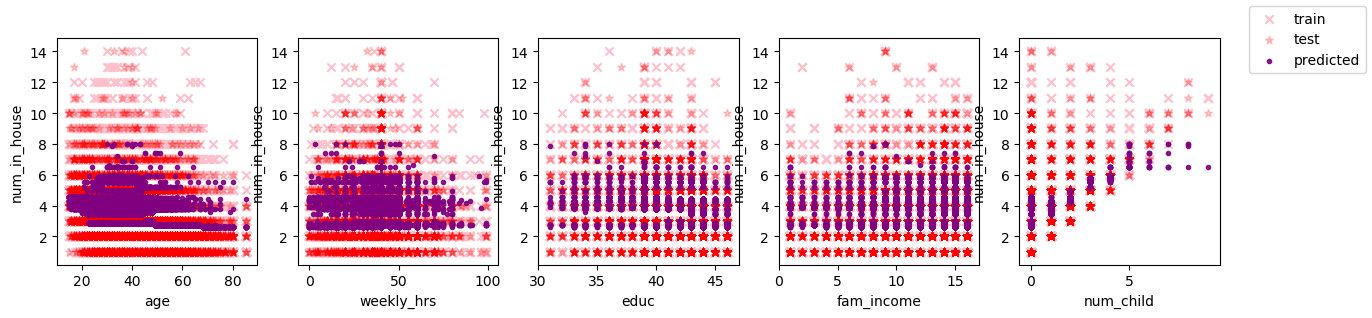

In [4]:
target = 'num_in_house'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));

plotPredictions(data_train, data_test, prediction, target)    

In [5]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)                 

R2 score : 0.25
Mean squared error: 1.83
MSE 1.826009215694225
variance 14.287336636506573
average of errors  1.8260092156942809
average of observed values 3.095195004976925
total sum of squares 26941.854854761244
ẗotal sum of residuals  20179.22784263688
r2 calculated 0.2510082193145382


In [6]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.21807607318864583

Linear Regression and Decision Tree Regression have very similar R2 scores, while AdaBoost is producing lower scores around .222. However, AdAboost produced lower variance than the other methods, and had the greatest MSE.

# Predict Number of own Children under 18 years of age

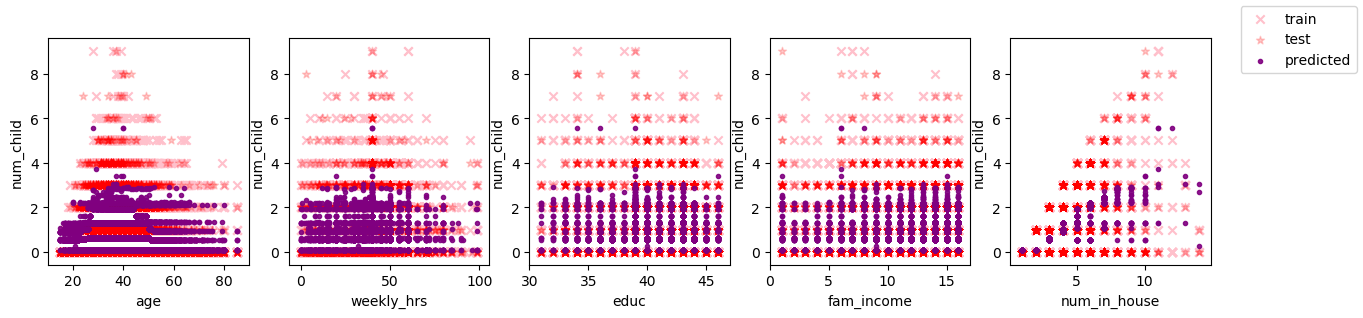

In [7]:
target = 'num_child'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)     

In [8]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.48
Mean squared error: 0.54
MSE 0.5425234466990211
variance 1.4078795644914086
average of errors  0.5425234466990333
average of observed values 0.6033843091122976
total sum of squares 11456.63342683986
ẗotal sum of residuals  5995.426609470882
r2 calculated 0.47668513200176377


In [9]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.46213653711229397

AdaBoost Regression for predicting num_child produces an R2 score that is significantly greater than the score produced by Linear Regression, but less than the score produced by Decision Tree Regression.

# Predict Family Income (Numerical Value)
Family income is represented by integers 1 - 16, each representing increaseng income groups ranging from 'less than 5,000' to 'greater than 150,000'. Refer to dataset description for more information.

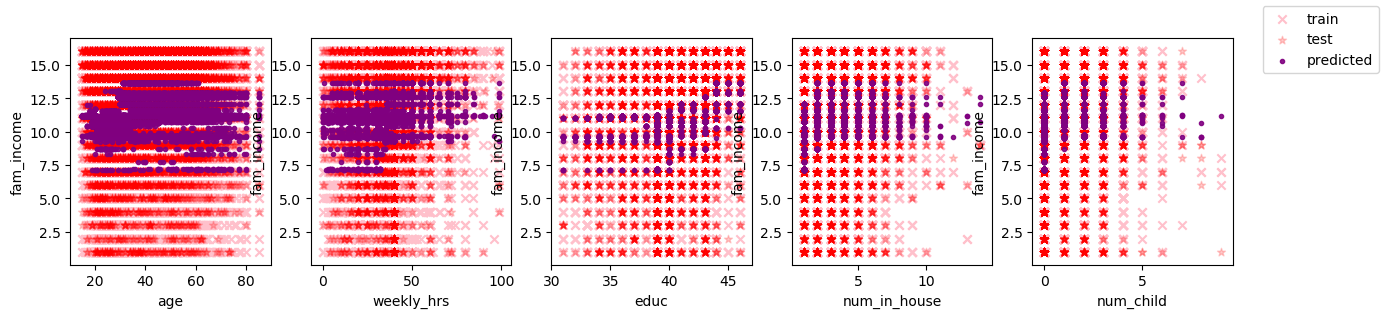

In [10]:
target = 'fam_income'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)    

In [11]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.16
Mean squared error: 10.26
MSE 10.257271049751205
variance 268.96193194315805
average of errors  10.257271049751347
average of observed values 12.21998009229934
total sum of squares 134446.22839561643
ẗotal sum of residuals  113353.10237080057
r2 calculated 0.15688893825082262


In [12]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.11941887464467822

The R2 score is very low when predicting family income. The R2 score produced using Decision Tree Regression has a slightly larger R2 score than the other methods. The variance, and MSE are similar for each of the regression methods used.

# Predict Age

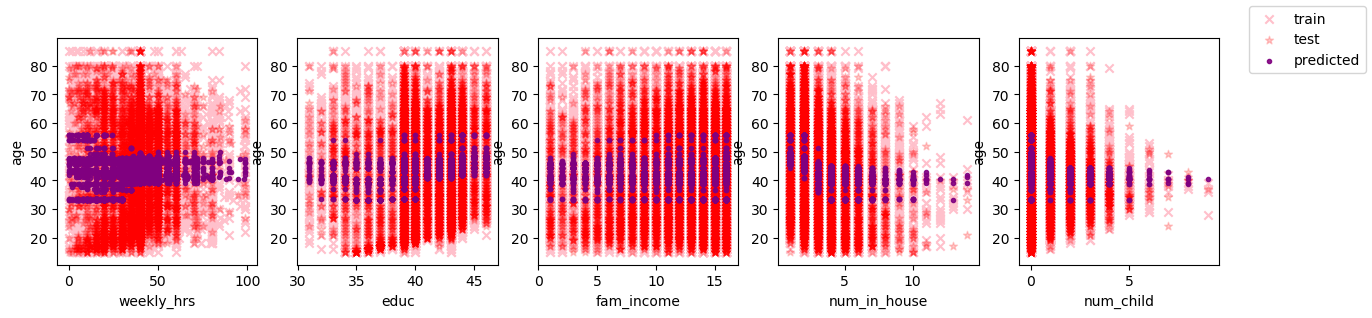

In [13]:
target = 'age'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [14]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)   

R2 score : 0.13
Mean squared error: 187.12
MSE 187.1182224058125
variance 40721.9438381918
average of errors  187.1182224058133
average of observed values 42.388652610623474
total sum of squares 2382795.737037357
ẗotal sum of residuals  2067843.475806634
r2 calculated 0.13217761654312765


In [15]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.11589463061405385

The R2 score is low for each method when predicting age.

# Predict Hours Worked Weekly

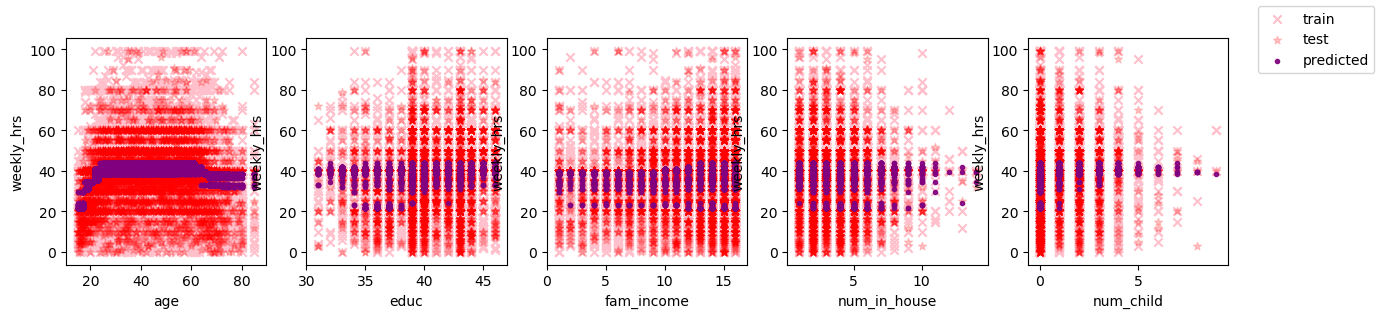

In [16]:
target = 'weekly_hrs'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [17]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)  

R2 score : 0.09
Mean squared error: 109.30
MSE 109.30413106222703
variance 71706.94989325412
average of errors  109.30413106222561
average of observed values 38.952221518414625
total sum of squares 1332968.7729617013
ẗotal sum of residuals  1207919.9523686708
r2 calculated 0.09381226562058653


In [18]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.09818702363960397

The R2 score is low for each method when predicting weekly_hrs.

# Predict Education Level
Education level is represented by integers 31-46, each representing increaseng levels of education from 'less than first grade' to 'doctorates degree'. Refer to dataset description for more information.

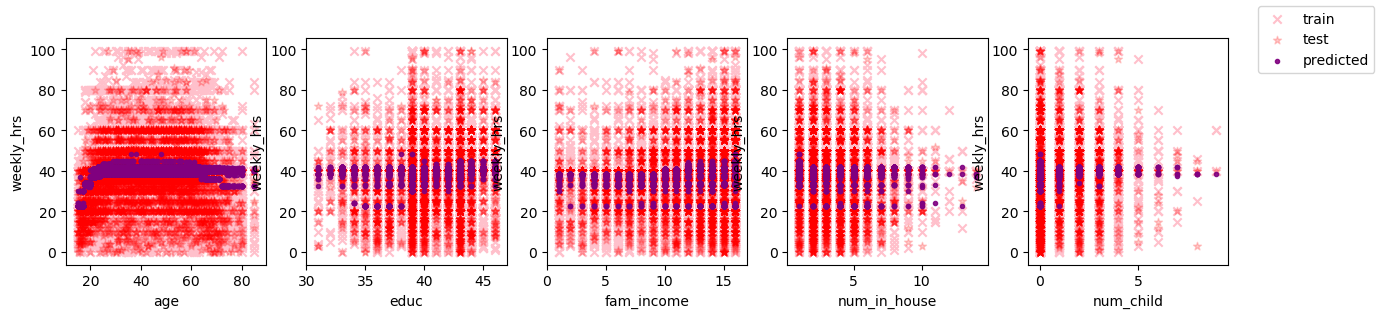

In [19]:
target = 'weekly_hrs'
T.fit(data_train.drop(target, axis=1), data_train[target])
prediction = T.predict(data_test.drop(target, axis=1));
plotPredictions(data_train, data_test, prediction, target)   

In [20]:
# Score Model
xTest = np.array(data_test.drop(target, axis=1))
yTest = np.array(data_test[target])
                 
x = data_train.drop(target, axis=1)
y = data_train[target]
                 
scoreAdaBoostRegressor(x, y, xTest, yTest)  

R2 score : 0.10
Mean squared error: 107.96
MSE 107.95877962972646
variance 69955.83157277617
average of errors  107.95877962972139
average of observed values 38.952221518414625
total sum of squares 1332968.7729617013
ẗotal sum of residuals  1193052.4736881072
r2 calculated 0.10496592426746532


In [21]:
# Score with cross validation
cvscore = cross_val_score(T, data.drop(target, axis=1), 
                          data[target], cv=KFold(shuffle=True, n_splits=5))
cvscore.mean()

0.0958274433791434

The R2 score is somewhat low for each method when predicting weekly_hrs, however Decision Tree Regression produces a significantly larger score.

# Conclusion

Although we predicted different variables from the dataset vs the categorical variables predicted when we use classification methods, the effectiveness of applying regression methods for predicting the numerical variables of this dataset aren't as effective as the results obtained in classification. Larger scores were produced when using supervised classification. Using regression to predict the binary categorical variables 'ismarried' and 'faminc_50' did not make sense using regression.

- The most effective prediction using supervised regression methods on this dataset was predicting 'Number of children under 18 years old' using Decision Tree Regression. The largest R2 score achieved was .5993. 
- The second most effective prediction using supervised regression methods on this dataset was predicting 'Number of Persons Living in Household' using Decision Tree Regression. The largest R2 score achieved was .4283

AdAboost was more effective than Linear Regression, but Decision Tree Regression proved to be the more effective regression method for this dataset.